# Predicting Loan Defaults with PyCaret
## Dr José M Albornoz
### November 2024

This notebook presents an example of how Pycarer it used to tackle a binary classification problem. The dataset used is the [Lending Club dataset from Kaggle](https://www.kaggle.com/datasets/wordsforthewise/lending-club), as it contains a mixture of numeric, categorical, date and text features.

# 0.- Imports & utility functions

In [4]:
import mlflow
import pycaret.classification as pyc
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib import cm
style.use('seaborn-colorblind')
%matplotlib inline

mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")

In [5]:
def plot_precision_recall_thresholds(y_true, y_scores, step, fontsize=10):

    """
    Plot a precision-recall curve with threshold values

    Parameters:
        y_true (float): true target value (1 or 0)
        y-scores (float): probability of the target being 1
        step (integer): spacing at which the threshold values will be displayed in the plot
        fontsize (integer): font size for threshold values
        
    """

    # Calculate precision, recall, and thresholds
    from sklearn.metrics import precision_recall_curve
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

    # creates threshold values and indexes for plotting 
    thresholds_sampled = thresholds[::step]
    idx_sampled = list(range(0, len(thresholds), step))
    idx = list(range(0, len(idx_sampled)))
    
    # Plot precision-recall curve
    plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    
    # Plot threshold points
    for i in idx:
        j = idx_sampled[i]
        t = thresholds_sampled[i]
        plt.annotate(f'{t:.2f}', (recall[j], precision[j]), textcoords="offset points", xytext=(0,5), ha='center', fontsize=fontsize)
    
    plt.legend()
    plt.title("Precision-Recall Curve with Thresholds")   

# 1.- Load data

In [7]:
# loading lending club dataset
import pandas as pd
data = pd.read_csv('../data/lendingclub.csv')

# sample so that only 10000 rows are considered (instead of 50000)
data = data.sample(10000, random_state=801).reset_index(drop=True)

# dropping features with no predictive power
data.drop(columns=['id', 'member_id', 'application_type'], inplace=True)
data.head()

,loan_amnt,funded_amnt,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,purpose,...,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,mths_since_last_major_derog,acc_now_delinq,tot_coll_amt,tot_cur_bal,risky_loan
0,13000,13000,412.80,A,A5,Affordable Repairs,10.0,OWN,45600.0,car,...,10959,36.7,13,f,0,NaN,0,0.0,37875.0,not_risky
1,3000,3000,109.20,D,D2,Equinox Fitness,4.0,RENT,35000.0,moving,...,11643,71.9,16,f,0,NaN,0,0.0,43479.0,not_risky
2,35000,35000,1309.49,E,E1,Pure Water Technology,4.0,RENT,100000.0,debt_consolidation,...,16400,72.6,18,f,0,NaN,0,0.0,41315.0,not_risky
3,10000,10000,304.36,A,A1,Partners health care,10.0,MORTGAGE,140000.0,house,...,14874,28.5,35,f,0,NaN,0,NaN,NaN,not_risky
4,4750,4750,174.24,D,D4,US Airways,2.0,RENT,26000.0,major_purchase,...,2171,18.9,14,f,0,NaN,0,0.0,21204.0,not_risky


In [8]:
data.shape

(10000, 31)

## 1.1.- Feature types

In [10]:
data.dtypes

loan_amnt                        int64
funded_amnt                      int64
installment                    float64
grade                           object
sub_grade                       object
emp_title                       object
emp_length                     float64
home_ownership                  object
annual_inc                     float64
purpose                         object
title                           object
zip_code                        object
addr_state                      object
dti                            float64
delinq_2yrs                      int64
earliest_cr_line                object
inq_last_6mths                   int64
mths_since_last_delinq         float64
mths_since_last_record         float64
open_acc                         int64
pub_rec                          int64
revol_bal                        int64
revol_util                     float64
total_acc                        int64
initial_list_status             object
collections_12_mths_ex_me

## 1.2.- Split into numeric, categorical, date and text features

In [12]:
data['earliest_cr_line'] = pd.to_datetime(data['earliest_cr_line'], format='%b-%y')

In [13]:
numeric_features = list(data.select_dtypes(include=[np.number]).columns)
non_numeric_features = list(data.select_dtypes(exclude=[np.number]).columns)

In [14]:
data[numeric_features].dtypes

loan_amnt                        int64
funded_amnt                      int64
installment                    float64
emp_length                     float64
annual_inc                     float64
dti                            float64
delinq_2yrs                      int64
inq_last_6mths                   int64
mths_since_last_delinq         float64
mths_since_last_record         float64
open_acc                         int64
pub_rec                          int64
revol_bal                        int64
revol_util                     float64
total_acc                        int64
collections_12_mths_ex_med       int64
mths_since_last_major_derog    float64
acc_now_delinq                   int64
tot_coll_amt                   float64
tot_cur_bal                    float64
dtype: object

In [15]:
text_features = ['emp_title', 'title', 'zip_code', 'addr_state']

In [16]:
date_features = ['earliest_cr_line']

In [17]:
categorical_features = [var for var in non_numeric_features if var not in text_features and var not in date_features]

In [18]:
categorical_features.remove('risky_loan')

In [19]:
data[categorical_features].dtypes

grade                  object
sub_grade              object
home_ownership         object
purpose                object
initial_list_status    object
dtype: object

In [20]:
data[categorical_features].nunique()

grade                   7
sub_grade              35
home_ownership          5
purpose                13
initial_list_status     2
dtype: int64

In [21]:
data[text_features].dtypes

emp_title     object
title         object
zip_code      object
addr_state    object
dtype: object

In [22]:
data[text_features].nunique()

emp_title     8377
title         3983
zip_code       731
addr_state      45
dtype: int64

## 1.3.- Class Balance

In [24]:
sum(data['risky_loan'] == 'not_risky')*100/data.shape[0]

83.56

In [25]:
sum(data['risky_loan'] == 'risky')*100/data.shape[0]

16.44

## 1.4.- Missing values

In [27]:
data.isnull().sum()

loan_amnt                         0
funded_amnt                       0
installment                       0
grade                             0
sub_grade                         0
emp_title                       541
emp_length                      338
home_ownership                    0
annual_inc                        0
purpose                           0
title                             0
zip_code                          0
addr_state                        0
dti                               0
delinq_2yrs                       0
earliest_cr_line                  0
inq_last_6mths                    0
mths_since_last_delinq         5610
mths_since_last_record         9469
open_acc                          0
pub_rec                           0
revol_bal                         0
revol_util                        8
total_acc                         0
initial_list_status               0
collections_12_mths_ex_med        0
mths_since_last_major_derog    8616
acc_now_delinq              

In [28]:
# Impute missing values in text features with 'N/A'
data[text_features] = data[text_features].fillna('N/A')

# 2.- Set up training environment and create transformation pipeline

In [30]:
# Set experiment name in MLFLow
EXPERIMENT_NAME = "experiment_1"
mlflow.set_experiment(EXPERIMENT_NAME)

<Experiment: artifact_location='mlflow-artifacts:/271874467815566131', creation_time=1730997048578, experiment_id='271874467815566131', last_update_time=1730997048578, lifecycle_stage='active', name='experiment_1', tags={}>

In [31]:
from pycaret.classification import *
s = setup(data, target = 'risky_loan', session_id = 801, 
         numeric_features = numeric_features,
         categorical_features = categorical_features,
         text_features = text_features, 
         date_features = date_features,
         fold = 5, numeric_imputation = 'median', normalize = True 
         )

,Description,Value
0,Session id,801
1,Target,risky_loan
2,Target type,Binary
3,Target mapping,"not_risky: 0, risky: 1"
4,Original data shape,"(10000, 31)"
5,Transformed data shape,"(10000, 8104)"
6,Transformed train set shape,"(7000, 8104)"
7,Transformed test set shape,"(3000, 8104)"
8,Numeric features,20
9,Date features,1


# 3.- Experiment setup

In [33]:
exp = ClassificationExperiment()

In [34]:
exp.setup(data, target = 'risky_loan', session_id = 801, log_experiment = True, experiment_name = EXPERIMENT_NAME)

,Description,Value
0,Session id,801
1,Target,risky_loan
2,Target type,Binary
3,Target mapping,"not_risky: 0, risky: 1"
4,Original data shape,"(10000, 31)"
5,Transformed data shape,"(10000, 55)"
6,Transformed train set shape,"(7000, 55)"
7,Transformed test set shape,"(3000, 55)"
8,Numeric features,20
9,Date features,1


## 3.1.- Find models that maximise AUC

In [36]:
best = pyc.compare_models(n_select = 5, sort="AUC")

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.8337,0.6392,0.8337,0.7609,0.7630,0.0101,0.0362,7.3420
lightgbm,Light Gradient Boosting Machine,0.8283,0.6253,0.8283,0.7542,0.7678,0.0341,0.0598,3.7120
xgboost,Extreme Gradient Boosting,0.8230,0.6163,0.8230,0.7473,0.7671,0.0350,0.0529,5.3500
ada,Ada Boost Classifier,0.8301,0.6109,0.8301,0.7539,0.7673,0.0311,0.0566,6.2700
rf,Random Forest Classifier,0.8356,0.6060,0.8356,0.6982,0.7607,0.0000,0.0000,3.9580
et,Extra Trees Classifier,0.8351,0.6005,0.8351,0.7146,0.7608,0.0003,0.0011,4.3460
svm,SVM - Linear Kernel,0.8171,0.5790,0.8171,0.7374,0.7633,0.0220,0.0312,12.5220
lr,Logistic Regression,0.7146,0.5459,0.7146,0.7395,0.7262,0.0511,0.0516,4.6400
dt,Decision Tree Classifier,0.7676,0.5375,0.7676,0.7480,0.7571,0.0814,0.0821,4.5600
ridge,Ridge Classifier,0.6370,0.5237,0.6370,0.7322,0.6748,0.0216,0.0234,6.7800


The model that gave us the best AUC is the Gradient Boosting Classifier. 

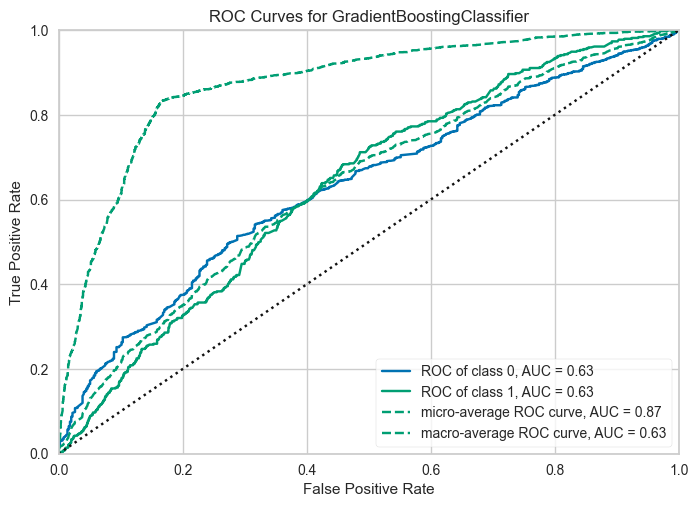

In [38]:
# plot AUC
plot_model(best[0], plot = 'auc')

## 3.2.- Plot precision-recall curve

In [40]:
X_test_transformed = get_config('X_test_transformed')

In [41]:
y_scores = best[0].predict_proba(X_test_transformed)[:,1]

In [42]:
y_true = get_config('y_test_transformed').to_numpy()

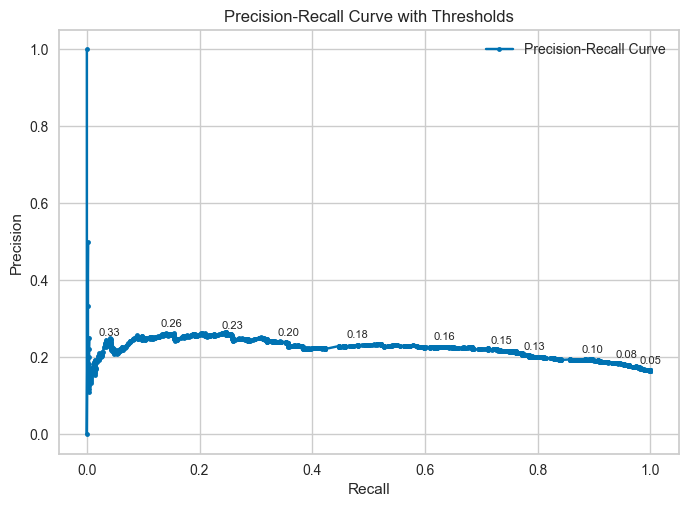

In [43]:
plot_precision_recall_thresholds(y_true, y_scores, 180, 8)

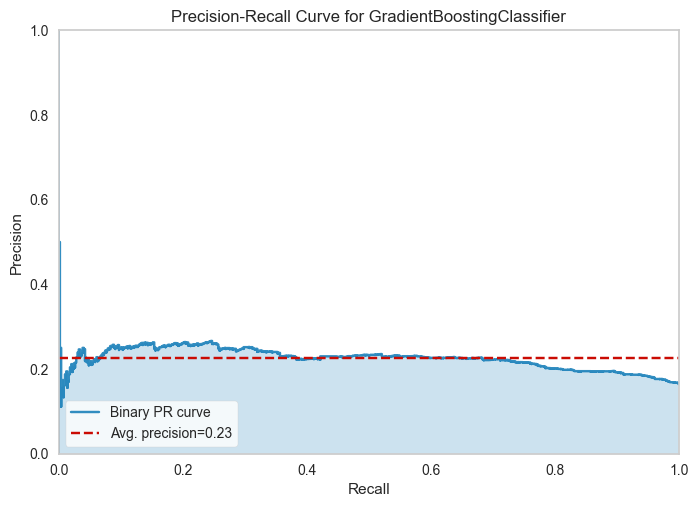

In [44]:
# plot precision-recall using pycaret's plotting 
plot_model(best[0], plot = 'pr')

## 3.3.- Plot confusion matrix

For the sake of this example, we are going to change the decision threshold of the model with the highest AUC.

In [47]:
gbc0 = create_model('gbc', fold = 5, probability_threshold = 0.26)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7857,0.6300,0.7857,0.7436,0.7612,0.0628,0.0660
1,0.7793,0.6399,0.7793,0.7397,0.7569,0.0483,0.0502
2,0.7850,0.6338,0.7850,0.7438,0.7612,0.0613,0.0641
3,0.7864,0.6446,0.7864,0.7529,0.7672,0.0941,0.0970
4,0.7843,0.6478,0.7843,0.7610,0.7713,0.1259,0.1277
Mean,0.7841,0.6392,0.7841,0.7482,0.7636,0.0785,0.0810
Std,0.0025,0.0066,0.0025,0.0077,0.0051,0.0281,0.0279


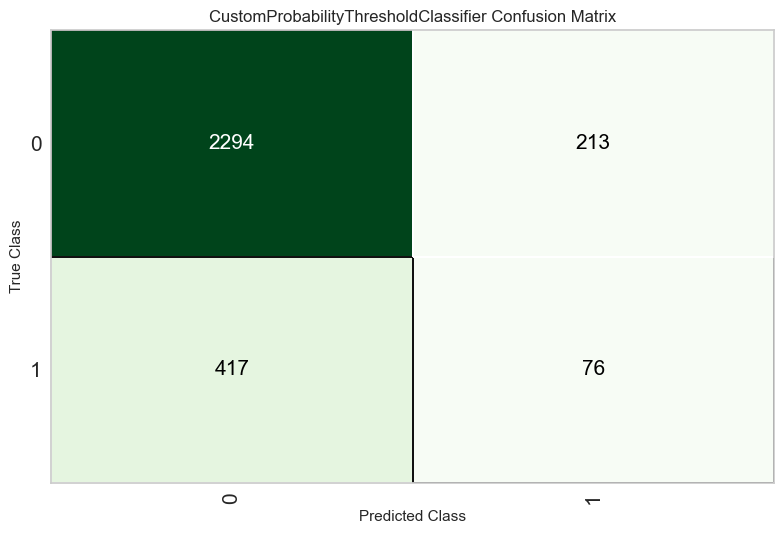

In [48]:
# plot confusion matrix
plot_model(gbc0, plot = 'confusion_matrix')

## 3.4.- Hyperparameter tuning

In [50]:
# tune model to optimise AUC
tuned_gbc = tune_model(gbc0, optimize = 'AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8350,0.6212,0.8350,0.6972,0.7599,0.0000,0.0000
1,0.8357,0.6653,0.8357,0.6984,0.7609,0.0000,0.0000
2,0.8357,0.6307,0.8357,0.6984,0.7609,0.0000,0.0000
3,0.8357,0.6219,0.8357,0.6984,0.7609,0.0000,0.0000
4,0.8357,0.6510,0.8357,0.6984,0.7609,0.0000,0.0000
Mean,0.8356,0.6380,0.8356,0.6982,0.7607,0.0000,0.0000
Std,0.0003,0.0174,0.0003,0.0005,0.0004,0.0000,0.0000


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


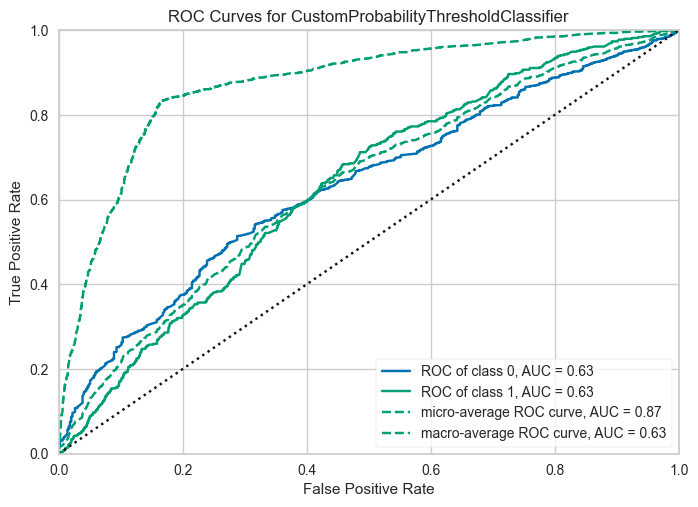

In [51]:
# plot AUC
plot_model(tuned_gbc, plot = 'auc')

In [52]:
y_scores = tuned_gbc.predict_proba(X_test_transformed)[:,1]

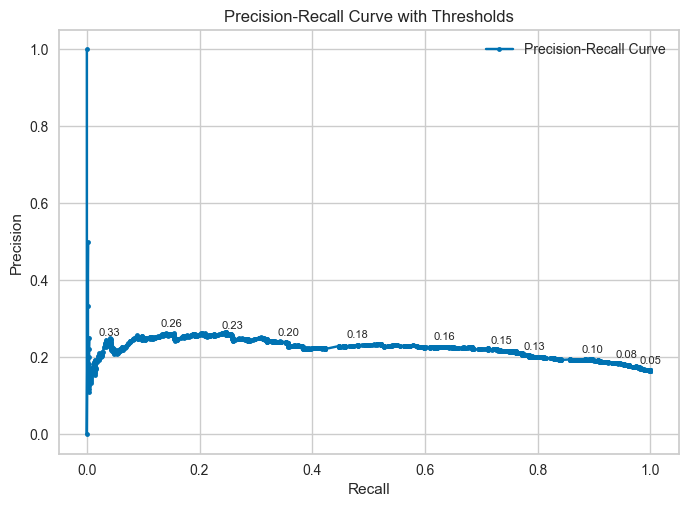

In [53]:
plot_precision_recall_thresholds(y_true, y_scores, 180, 8)

Let's plot the confusion matrix for the tuned model for the same threshold we used before (0.26)

In [55]:
y_pred = []
threshold = 0.26
for val in y_scores:
    if val >= threshold:
        y_pred.append(1)
    else:
        y_pred.append(0)

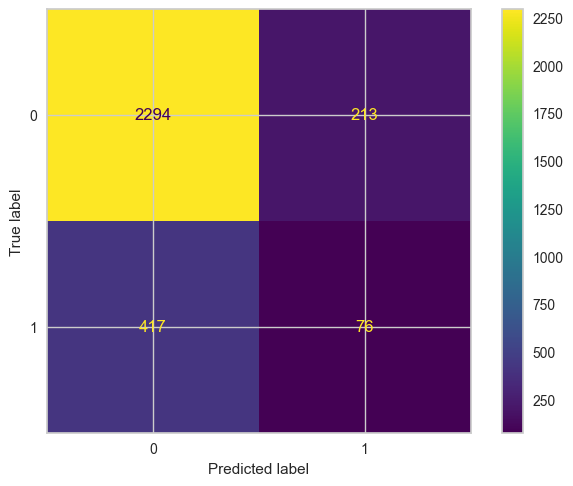

In [56]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true, y_pred, labels=tuned_gbc.classes_)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tuned_gbc.classes_).plot()

An alternate to `plot_model` function is `evaluate_model`. It can only be used in Notebook since it uses `ipywidget`.

In [58]:
evaluate_model(tuned_gbc)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

# 4.- Prediction

The `predict_model` function returns `prediction_label` and `prediction_score` (probability of the predicted class) as new columns in dataframe. When data is `None` (default), it uses the test set (created during the setup function) for scoring.

In [105]:
# predict on test set
holdout_pred = predict_model(tuned_gbc, probability_threshold = 0.26)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.7900,0.6334,0.7900,0.7503,0.7667,0.0830,0.0869


In [107]:
# show predictions df
holdout_pred.head()

,loan_amnt,funded_amnt,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,purpose,...,total_acc,initial_list_status,collections_12_mths_ex_med,mths_since_last_major_derog,acc_now_delinq,tot_coll_amt,tot_cur_bal,risky_loan,prediction_label,prediction_score
2768,10000,10000,317.540009,A,A5,Ephrata Community Hospital,10.0,RENT,63000.0,debt_consolidation,...,39,f,0,NaN,0,NaN,NaN,not_risky,not_risky,0.9407
835,8000,8000,288.299988,D,D1,"TROPICANA PRODUCTS, INC.",10.0,RENT,44750.0,debt_consolidation,...,18,f,0,46.0,0,0.0,6774.0,not_risky,not_risky,0.7806
355,15000,15000,546.440002,D,D4,PPG,1.0,RENT,30000.0,debt_consolidation,...,25,f,0,NaN,0,NaN,NaN,not_risky,risky,0.3012
2200,10000,10000,348.179993,C,C2,hotel mela,5.0,RENT,55000.0,credit_card,...,21,f,0,NaN,0,NaN,NaN,risky,not_risky,0.8501
475,19800,19800,565.369995,F,F3,MPSC,3.0,RENT,44000.0,debt_consolidation,...,26,f,0,49.0,0,0.0,36019.0,not_risky,risky,0.3092


# 5.- Save model

Finally, you can save the entire pipeline on disk for later use, using pycaret's `save_model` function.

In [111]:
# save pipeline
save_model(tuned_gbc, 'lending_club_model_v1')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('label_encoding',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=LabelEncoder())),
                 ('date_feature_extractor',
                  TransformerWrapper(exclude=None, include=['earliest_cr_line'],
                                     transformer=ExtractDateTimeFeatures(features=['day',
                                                                                   'month',
                                                                                   'year']))),
                 ('numerical_imputer',
                  TransformerWrapper(excl...
                                                       learning_rate=0.1,
                                                       loss='log_loss',
                                                       max_depth=3,
                                                       max_features=No

In [113]:
# load pipeline
loaded_best_pipeline = load_model('lending_club_model_v1')
loaded_best_pipeline

Transformation Pipeline and Model Successfully Loaded


Pipeline(memory=FastMemory(location=/var/folders/wf/3tthnv696c766yz5blpdyy1h0000gp/T/joblib),
         steps=[('label_encoding',
                 TransformerWrapperWithInverse(exclude=None, include=None,
                                               transformer=LabelEncoder())),
                ('date_feature_extractor',
                 TransformerWrapper(exclude=None, include=['earliest_cr_line'],
                                    transformer=ExtractDateTimeFeatures(features=['day',
                                                                                  'month',...
                                                      learning_rate=0.1,
                                                      loss='log_loss',
                                                      max_depth=3,
                                                      max_features=None,
                                                      max_leaf_nodes=None,
                                                      min_impurity_decrease=0.0,
                                                      min_samples_leaf=1,
                                                      min_samples_split=2,
                                                      min_weight_fraction_leaf=0.0,
                                                      n_estimators=100,
                                                      n_iter_no_change=None,
                                                      probability_threshold=0.26,
                                                      random_state=801,
                                                      subsample=1.0, tol=0.0001,
                                                      validation_fraction=0.1,
                                                      verbose=0,
                                                      warm_start=False))],
         verbose=False)